In [1]:
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import numpy as np
import sys
%matplotlib inline

In [12]:
def time_in_seconds(val):
    if "-" in val:
        fields = val.split("-")
        sec=0.0
        for i in fields:
            if 's' in i: sec += float(i.strip('s'))
            if 'm' in i: sec += 60 * float(i.strip('m'))
            if 'h' in i: sec += 3600 * float(i.strip('h'))
        return sec
    else:
        if 'h' in val:
            fields = val.split('h')
            sec = 3600 * float(fields[0]) + 60 * float(fields[1].strip('m'))
            return sec
        elif 'm' in val:
            fields = val.split('m')
            sec = 60 * float(fields[0]) + float(fields[1].strip('s'))
            return sec
        else:
            return float(val.strip("s"))

In [20]:
def parse_report(file_name):
    buffer = []
    resources_dict = {
        "MPI Cores": "mpi", "Threads per core": "thrs", "Threads total": "thr_tot", 
        "Nodes Computing": "nodes", "Nodes IO": "nodes_io", "MPI tasks / GPU": "mpi/gpu",
    }
    resources = {}
    timing = {}
    log = False
    with open(file_name, 'r') as report:
        for line in report:
            if line == "\n": log = False
            if log: 
                buffer.append(line.strip())
            else:
                for key, val in resources_dict.items():
                    if key in line: resources[val] = int(line.strip().split(":")[1])
                if "Time-Profile" in line:
                    timing["Time-Profile"] = time_in_seconds(line.strip().split(":")[1])

            if "Routines: global" in line: log = True

    for line in buffer:
        fields = line.split(":")
        timing[fields[0].strip()] = time_in_seconds(fields[1].strip().split()[0])
    return resources, timing

In [4]:
def build_dataframe(x_axis='mpi', factor=1, rename_cols={}):
    r_files = glob("r-*")

    data = {}
    for report in r_files:
        resources, timing = parse_report(report)
        for key, val in resources.items():
            if key in data:
                data[key].append(val)
            else:
                data[key] = [val,]
        for key, val in timing.items():
            if key in data:
                data[key].append(val)
            else:
                data[key] = [val,]
    
    scaling = pd.DataFrame(data)
    if rename_cols: 
        scaling.rename(columns=rename_cols, inplace=True)
    else:
        scaling.rename(columns={'Xo (procedure)': 'Xo', 'X (procedure)': 'X'}, inplace=True)
    scaling.sort_values(by=[x_axis], inplace=True)
    if 'mpi/gpu' in scaling: scaling['gpu'] = pd.Series(scaling['mpi'] / scaling['mpi/gpu'], dtype=np.int64)
    scaling['ideal'] = scaling[x_axis] / factor
    scaling['speedup'] = scaling[scaling[x_axis]>=factor]['Time-Profile'].max() / scaling['Time-Profile']
    scaling['efficiency'] = scaling.speedup / scaling.ideal * 100
    scaling['Self energy'] = scaling['HF'] + scaling['GW(ppa)']
    scaling['Other'] = scaling['Time-Profile'] - scaling['Dipoles'] - scaling['Xo'] - scaling['X'] - scaling['Self energy']
    scaling['node_h'] = scaling['nodes'] * scaling['Time-Profile'] / 3600
    return scaling

In [31]:
def build_scaling_plot(scaling, pile, colors, x_axis='mpi', x_label='MPI tasks', bar_width=1,
                       title=None, legend_loc=None, label=None, label_pos=None, efficiency=True, file_name='scaling.png'):
    if len(pile) != len(colors):
        sys.stderr.write("Error: the number of elements of pile and colors lists have to be the same.")
        return
    fig, ax1 = plt.subplots(figsize=(10, 7))

    bottom = pd.Series(dtype='float64')
    for key, color in zip(pile, colors):
        if bottom.empty:
            ax1.bar(scaling[x_axis], scaling[key], width=bar_width, color=color, label=key)
            bottom = scaling[key].copy()
        else:
            ax1.bar(scaling[x_axis], scaling[key], width=bar_width, color=color, label=key, bottom=bottom)
            bottom += scaling[key]

    ax1.set_xlabel(x_label,fontsize=20)
    ax1.set_ylabel('Time (sec)',fontsize=20)
    ax1.legend()
    if legend_loc: ax1.legend(fontsize='18',framealpha=0.0, loc=legend_loc)
    ax1.tick_params(axis = 'both', which = 'major', labelsize = 18)
    if label and label_pos: ax1.text(*label_pos, label, fontsize=20)
    plt.xticks(scaling[x_axis])
    
    if efficiency:
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylim([-10, 110])
        ax2.set_ylabel('Efficiency (%)', color='tab:blue',fontsize=20)  # we already handled the x-label with ax1
        ax2.plot(scaling[x_axis], scaling['efficiency'], linewidth=3, color='tab:blue')
        ax2.tick_params(axis='y', labelcolor='tab:blue', labelsize=18)
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    if title: plt.title(title, fontsize=20)
    plt.savefig(file_name, bbox_inches='tight')

In [6]:
def build_cost_plot(scaling, label='yambo', title=None, y_lim=None, file_name='cost.pdf'):
    fig2, ax3 = plt.subplots(figsize=(10, 7))
    ax3.set_xlabel('Time to solution (sec)',fontsize=20)
    ax3.set_ylabel('Cost (node*hour)',fontsize=20)
    ax3.plot(scaling['Time-Profile'][2:], scaling['node_h'][2:], 
             linewidth=3, color=colors[0], marker='.', markersize=15,
             label=label)
    if y_lim: ax3.set_ylim(y_lim)
    ax3.legend()
    ax3.legend(fontsize='18',framealpha=0.0)

    if title: plt.title(title, fontsize=20)
    plt.savefig(file_name)

In [21]:
scaling = build_dataframe(x_axis='mpi', factor=80)
scaling

mpi  thrs  thr_tot  nodes  nodes_io  Time-Profile   io_WF  io_GROT  \
6   80    32     2560     20         1        1796.0  2.8839   0.0271   
0  160    32     5120     40         1        1025.0  2.6732   0.0254   
4  320    32    10240     80         1         510.0  2.6024   0.0262   
2  480    32    15360    120         1         371.0  3.2471   0.0247   
3  640    32    20480    160         1         304.0  1.0638   0.0248   
1  800    32    25600    200         1         285.0  7.7058   0.0242   
5  960    32    30720    240         1         215.0  4.5175   0.0248   

   io_QINDX  io_COL_CUT  ...  XC_potential_driver  GW(ppa)  GW(REDUX)  \
6    0.0201      0.0001  ...               4.2359  12.7836     0.4313   
0    0.0045      0.0002  ...               4.1980   6.7998     0.4678   
4    0.0048      0.0002  ...               4.1557   4.0862     0.2265   
2    0.0054      0.0001  ...               4.6477   3.2450     0.4782   
3    0.0057      0.0002  ...               4.5412   3.0007     0.3501   
1    0.0057      0.0001  ...               4.4082   3.2236     0.5122   
5    0.0053      0.0002  ...               4.4257   2.8768     0.4596   

   io_QP_and_GF  ideal   speedup  efficiency  Self energy    Other     node_h  
6        0.0521    1.0  1.000000  100.000000      16.9497  16.0009   9.977778  
0        0.0545    2.0  1.752195   87.609756       9.4550  16.3883  11.388889  
4        0.0517    4.0  3.521569   88.039216       5.9302  16.1900  11.333333  
2        0.0552    6.0  4.840970   80.682839       4.8782  21.2163  12.366667  
3        0.0520    8.0  5.907895   73.848684       4.4171  22.5507  13.511111  
1        0.0547   10.0  6.301754   63.017544       3.8321  29.8261  15.833333  
5        0.0519   12.0  8.353488   69.612403       3.3814  26.6701  14.333333  

[7 rows x 50 columns]

In [22]:
colors=['#2EA6A6', '#F28F38', '#47AB6C', '#112F41', '#D90718']
pile = ['Dipoles', 'Xo', 'X', 'Self energy', 'Other']
scaling[['mpi', 'Time-Profile'] + pile]

mpi  Time-Profile    Dipoles        Xo       X  Self energy    Other
6   80        1796.0  1623.0000  132.1358  7.9136      16.9497  16.0009
0  160        1025.0   827.0000  165.7774  6.3793       9.4550  16.3883
4  320         510.0   441.6614   43.3924  2.8260       5.9302  16.1900
2  480         371.0   298.6063   38.8259  7.4733       4.8782  21.2163
3  640         304.0   254.5834   20.4671  1.9817       4.4171  22.5507
1  800         285.0   212.9672   35.5030  2.8716       3.8321  29.8261
5  960         215.0   168.9603   14.4460  1.5422       3.3814  26.6701

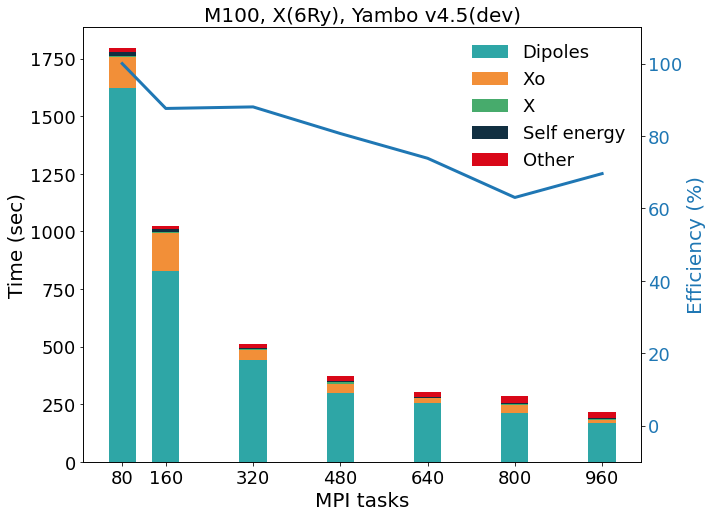

In [32]:
build_scaling_plot(scaling=scaling, pile=pile, colors=colors, bar_width=50, efficiency=True,
                   legend_loc='upper right', title=r'M100, X(6Ry), Yambo v4.5(dev)', 
                   file_name='scaling_20nodes.png')

In [10]:
io_cols=['mpi', 'io_ATMPROJ_pwscf', 'io_KB_abinit', 'io_BS', 'io_Double_Grid', 'io_COL_CUT', 'PP_uspp_init', 'io_HF', 'IO_and_Messaging_switch', 'io_QINDX', 'io_KB_pwscf', 'io_DIPOLES', 'io_fragment', 'io_WF']
scaling[io_cols]

mpi  io_ATMPROJ_pwscf  io_KB_abinit   io_BS  io_Double_Grid  io_COL_CUT  \
3   20            0.0000        0.0000  0.0001          0.0002      0.0003   
6   40            0.0001        0.0001  0.0002          0.0008      0.0071   
4   60            0.0001        0.0001  0.0002          0.0026      0.0111   
0   80            0.0001        0.0001  0.0002          0.0021      0.0004   
1  100            0.0001        0.0001  0.0002          0.0035      0.0003   
7  120            0.0001        0.0001  0.0001          0.0011      0.0004   
2  140            0.0001        0.0001  0.0002          0.0010      0.0003   
5  160            0.0001        0.0001  0.0002          0.0078      0.0003   

   PP_uspp_init   io_HF  IO_and_Messaging_switch  io_QINDX  io_KB_pwscf  \
3        0.0006  0.0223                   0.0005    0.0053       0.4134   
6        0.0006  0.0227                   0.0005    0.0322       0.2907   
4        0.0007  0.0242                   0.0005    0.0269       0.3551   
0        0.0008  0.0239                   0.0005    0.0264       0.2707   
1        0.0010  0.0226                   0.0005    0.0074       0.3951   
7        0.0007  0.0258                   0.0005    0.0186       0.4221   
2        0.0007  0.0234                   0.0005    0.0062       0.3276   
5        0.0008  0.0395                   0.0005    0.0178       0.4498   

   io_DIPOLES  io_fragment    io_WF  
3      1.2631       1.4253  10.7221  
6      1.2526       1.2499   7.3285  
4      1.2824       1.5005   5.6649  
0      1.2174       1.0668   4.9759  
1      1.1875       1.1679   4.5199  
7      1.1405       1.4336   4.2144  
2      1.3039       0.8561   3.0165  
5      2.7161       3.1497   3.6317